In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

import pathlib as plb

In [2]:
WORK_DIR = plb.Path().resolve().parent
DATA_DIR = WORK_DIR / "data"
NOTEBOOKS_DIR = WORK_DIR / "notebooks"
SCRIPTS_DIR = WORK_DIR / "scripts"

HH_DIR = DATA_DIR / "Form 2"

In [3]:
import sys
sys.path.append(str(WORK_DIR))

from scripts import pop_variables as popv
from scripts import psgc as psgc

In [4]:
[x for x in HH_DIR.iterdir() if x.is_dir()]

[WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 1 ILOCOS'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 10 NORTHERN MINDANAO'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 11 DAVAO'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 12 SOCCSKSARGEN'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 13 NCR'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 14 CAR'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 15 ARMM'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 16 CARAGA'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 2 CAGAYAN VALLEY'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 3 CENTRAL LUZON'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2

In [5]:
TEST_DIR = HH_DIR / "Region 1 ILOCOS" / "Ilocos Norte"

name_geolocation = TEST_DIR.name

fp_test_pop = TEST_DIR / f"POPCEN PUF 2015 {name_geolocation} Population.csv"

assert fp_test_pop.exists()

In [6]:
df_test_pop = pd.read_csv(fp_test_pop, na_values=[" " * i for i in range(1, 4)])
df_test_pop.head()

,REG,PRV,PRV_HUC,MUN,BGY,URB,HUSN,HSN,LNO,P2,...,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
0,1,28,2800,1,1,0,1,1,1,1,...,1,2,43,NaN,1.0,130.0,2.0,NaN,2.0,61.0
1,1,28,2800,1,1,0,1,1,2,2,...,1,2,43,NaN,1.0,170.0,2.0,NaN,2.0,9.0
2,1,28,2800,1,1,0,1,1,3,3,...,1,1,38,2.0,1.0,250.0,2.0,NaN,2.0,93.0
3,1,28,2800,1,1,0,1,1,4,4,...,1,1,38,1.0,1.0,170.0,NaN,NaN,NaN,NaN
4,1,28,2800,1,1,0,1,1,5,4,...,1,1,38,1.0,1.0,120.0,NaN,NaN,NaN,NaN


In [7]:
df_test_pop["BGY_PSGC"] = psgc.get_brgy_psgc(df_test_pop)

In [8]:
dict_pop_variables = {
    "nPOP": popv.population(df_test_pop),
    "rSX": popv.sex_ratio(df_test_pop),
    "nPWA": popv.working_age_population(df_test_pop),
    "rYD": popv.youth_dependency_ratio(df_test_pop),
    "rOD": popv.old_age_dependency_ratio(df_test_pop),
    "rSA": popv.school_attendance_rate(df_test_pop),
    "rLT": popv.literacy_rate(df_test_pop),
    "mYS": popv.mean_years_schooling(df_test_pop),
    "ptOFW": popv.ofw_per_1k_people(df_test_pop)
}

df_popv_brgy = pd.DataFrame(dict_pop_variables).reset_index()
df_popv_brgy

,BGY_PSGC,nPOP,rSX,nPWA,rYD,rOD,rSA,rLT,mYS,ptOFW
0,PH012801001,1792,117.212,1147,47.515,8.718,67.013,91.963,8.045,32.366
1,PH012802001,853,101.655,563,41.741,9.769,72.614,98.658,10.252,37.515
2,PH012802002,1596,100.755,1021,47.992,8.325,71.564,98.821,10.164,36.967
3,PH012802003,1413,105.378,936,41.453,9.509,65.549,98.684,9.823,46.709
4,PH012802004,733,103.611,507,30.769,13.807,65.984,97.829,10.387,45.020
...,...,...,...,...,...,...,...,...,...,...
552,PH012823052,1221,102.824,812,36.946,13.424,69.231,99.367,10.824,27.846
553,PH012823053,1064,92.754,701,37.233,14.551,75.989,98.592,11.382,39.474
554,PH012823054,1033,92.007,693,35.498,13.564,70.255,98.340,11.412,52.275
555,PH012823056,1346,105.496,860,40.349,16.163,64.286,95.710,9.225,100.297


<Axes: ylabel='Frequency'>

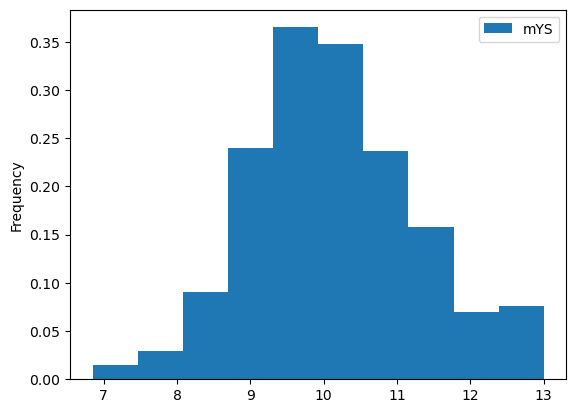

In [9]:
df_popv_brgy.plot(
    kind="hist",
    x="BGY_PSGC",
    y="mYS",
    density=True
)

<Axes: ylabel='Density'>

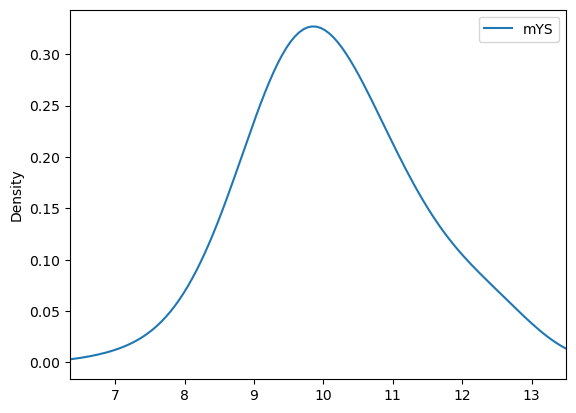

In [10]:
target_var = "mYS"

df_popv_brgy.plot(
    kind="density",
    x="BGY_PSGC",
    y=target_var,
    ind=200,
    bw_method=0.5,
    xlim=[df_popv_brgy[target_var].min() - 0.5, df_popv_brgy[target_var].max() + 0.5]
)

In [11]:
df_popv_brgy.columns.values.tolist()

['BGY_PSGC', 'nPOP', 'rSX', 'nPWA', 'rYD', 'rOD', 'rSA', 'rLT', 'mYS', 'ptOFW']

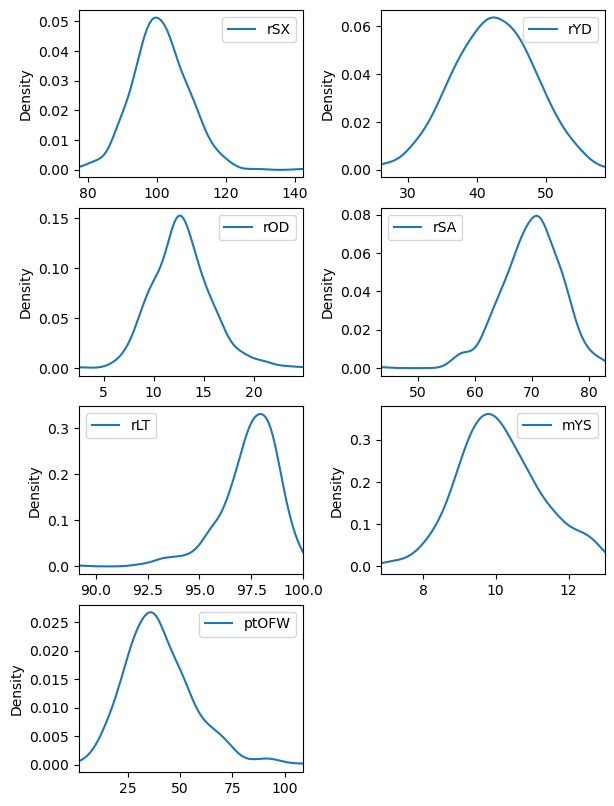

In [12]:
target_vars = df_popv_brgy.columns.values.tolist()[1:]
for var in target_vars:
    if var.startswith("n"):
        target_vars.remove(var)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 8), )
for ax, var in zip(axes.ravel()[:-1], target_vars):
    df_popv_brgy.plot(
        kind="density",
        ax=ax,
        x="BGY_PSGC",
        y=var,
        ind=200,
        bw_method=0.3,
        xlim=[df_popv_brgy[var].min(), df_popv_brgy[var].max()],
        # ylim=[0.0, 0.45]
    )

axes.ravel()[-1].set_axis_off()
plt.tight_layout(pad=0.5)
# plt.subplots_adjust(
#     # left=0.01,
#     right=0.99
# )
# plt.margins(x=1)
# axes.ravel()

In [13]:
fp_test_hh = TEST_DIR / "POPCEN PUF 2015 Ilocos Norte Housing.csv"

assert fp_test_hh.exists()

In [14]:
df_test_hh = pd.read_csv(fp_test_hh, na_values=[" " * i for i in range(1, 3)])
df_test_hh.head()

,REG,PRV,PRV_HUC,MUN,BGY,URB,HUSN,HSN,B1,B2,B3,H1,H2,H3,H4,FIRSTHH
0,1,28,2800,1,1,0,1,1,1,1,3,1.0,1.0,1.0,1.0,1.0
1,1,28,2800,1,1,0,2,2,1,1,3,1.0,1.0,1.0,1.0,1.0
2,1,28,2800,1,1,0,3,3,1,1,3,1.0,1.0,1.0,1.0,1.0
3,1,28,2800,1,1,0,4,4,1,1,2,1.0,1.0,1.0,1.0,1.0
4,1,28,2800,1,1,0,5,5,1,1,3,1.0,1.0,1.0,1.0,1.0


In [15]:
df_test_hh["BGY_PSGC"] = psgc.get_brgy_psgc(df_test_hh)

In [20]:
df_hhv_brgy = pd.DataFrame(df_test_hh.groupby("BGY_PSGC")["HUSN"].count()).reset_index()
df_hhv_brgy = df_hhv_brgy.rename(columns={"HUSN": "nHH"})
df_hhv_brgy.head()

,BGY_PSGC,nHH
0,PH012801001,509
1,PH012802001,260
2,PH012802002,383
3,PH012802003,415
4,PH012802004,236


In [ ]:
pd.crosstab(
    index=[df_test_hh[col] for col in ["B" + str(i) for i in range(1, 4)]],
    columns=[df_test_hh[col] for col in ["H" + str(j) for j in range(1, 5)]],
    margins=True
)

In [ ]:
pd.crosstab(
    index=[df_test_hh["H2"], df_test_hh["H3"]],
    columns=[df_test_hh["H1"]]
)

In [ ]:
pd.crosstab?